In [1]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
# !pip install awkward pandas
import awkward as ak
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()
# import ROOT

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions

CHAMBERS = {
     "BIS7A02": "ntuple_data/data24_calib.00476785.calibration_MuonAll.daq.RAW.0001_0004-0113.ntuple.root"
    # "BIS7A02": '/eos/user/z/zyan/SWAN_projects/mdtCalibrationAnalysis/mdtAnalysisRun3/cbnt_run476785_24latest/data24_calib.00476785.calibration_MuonAll.daq.RAW.0001_0004-0113.ntuple.root',
    # "BIS7A04": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0114.ntuple.root',
    # "BIS7A06": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0115.ntuple.root',
    # "BIS7A08": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0116.ntuple.root',
    # "BIS7A10": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0117.ntuple.root',
    # "BIS7A12": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0118.ntuple.root',
    # "BIS7A14": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0119.ntuple.root'
}

OP_CHAMBER='BIS7A02' 
ACTIVE_TIME_WINDOW=1.3*(10**(-6))
ADC_CUT_VAL = 50
# NOISE_THRESH=20000


inputCalibNtuple=CHAMBERS[OP_CHAMBER] 
f=uproot.open(inputCalibNtuple)  
tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
        
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

process run 047678 lumiblock 0001_0004 region 113, chamberList ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02']


In [2]:
df_all = tree.arrays() #gives total numner of events and not hits
total_evts=len(df_all)

print(f'Total Events in this data file is {total_evts}')

df_raw=ak.to_pandas(tree.arrays(branchMapping['rawMdt'])) #convert awkward array to dataframe 
df_raw.columns
# df_raw['rawMdt_id']

Total Events in this data file is 8406


Index(['rawMdt_adc', 'rawMdt_gPosX', 'rawMdt_gPosY', 'rawMdt_gPosZ',
       'rawMdt_id', 'rawMdt_nRMdt', 'rawMdt_tdc'],
      dtype='object')

In [3]:
# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_chamber'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])
print(f'Total number of rows and columns in chambers {chamberInRegion} is {df_raw.shape}')

# Creates new dataframe that only contains data for current chamber
df_op_chamber = df_raw[df_raw['rawMdt_station']==OP_CHAMBER]
print(f'Total number of rows and columns in {OP_CHAMBER} is {df_op_chamber.shape}')

Total number of rows and columns in chambers ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02'] is (881189, 10)
Total number of rows and columns in BIS7A02 is (0, 10)


In [12]:
print(df_raw.iloc[:2,9] ) 
print(df_raw.head(5))

entry  subentry
0      0           BIS
       1           BIS
Name: rawMdt_station, dtype: object
                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                133   4309.250977   1780.442993   6397.052734   
      1                149   4309.225586   1780.475342   6381.952148   
      2                 60   4309.098633   1780.637329   6306.449219   
      3                294   4308.743652   1781.090942   6095.041504   
      4                257   4308.718262   1781.123413   6079.941406   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649644            95         231  BIS7A02-2-4-45   
      1          24649643            95         303  BIS7A02-2-4-44   
      2          24649638            95         688  BIS7A02-2-4-39   
      3          24649624            95   

In [9]:
# Define the function to extract chamber and station info
start_time = time.time()

#took 273.40 seconds
def extract_info(rawMdt_id):
    tube_info = chamberlist_run3.MDTtubename(int(rawMdt_id))
    chamber = tube_info[:7]
    station = tube_info[:3]
    return tube_info, chamber, station

# Apply the function once and assign the results to new columns
df_raw[['rawMdt_tubeInfo', 'rawMdt_chamber', 'rawMdt_station']] = df_raw['rawMdt_id'].apply(lambda x: pd.Series(extract_info(x)))
end_time=time.time()

elapsed_time=end_time-start_time
print(f'elapsed_time : {elapsed_time}')
print(f'Total number of rows and columns in chambers {chamberInRegion} is {df_raw.shape}')

elapsed_time : 273.3955681324005
Total number of rows and columns in chambers ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02'] is (881189, 10)


In [10]:
# df_raw.iloc[190:210]
df_raw.head()
#adc-> is it measuring the current? units?
#what is the difference b/w global and local position here?

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                133   4309.250977   1780.442993   6397.052734   
      1                149   4309.225586   1780.475342   6381.952148   
      2                 60   4309.098633   1780.637329   6306.449219   
      3                294   4308.743652   1781.090942   6095.041504   
      4                257   4308.718262   1781.123413   6079.941406   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649644            95         231  BIS7A02-2-4-45   
      1          24649643            95         303  BIS7A02-2-4-44   
      2          24649638            95         688  BIS7A02-2-4-39   
      3          24649624            95         575  BIS7A02-2-4-25   
      4          24649623            95         578  BIS7A02-2-4-24   

               rawMdt_chamber rawMdt_station  
entry subentry                                
0     0               BIS7A02            BIS  
      1               BIS7A02            BIS  
      2               BIS7A02            BIS  
      3               BIS7A02            BIS  
      4               BIS7A02            BIS

In [15]:
df_raw['rawMdt_tdc'].unique() #tdc: time to digital converter; t_1 - t_0 -> t_1 is drift time and t_0 is time recorded from the scintillator
#units of tdc ??

array([ 231,  303,  688, ..., 1606, 1605, 1610], dtype=int32)

In [54]:
print(tree.keys()) #event_LVL2Pt, event_eventNumber; Pt: energy(high Pt: 20GeV cut is the threshold; to make sure we are working with high momentum muon
# 2.  rawHit: already applied adc cut 50; 
# 3. rawMdt branch:  
# trkHit branches are now only MDTs : 
# type: 1, 4; 1: good mdt trkhits; 4: outlier hits(residual > 5 sigma ie error on the tracks)
# ->try to plot the outliers hitmap: check type 1: good hits hitmap for mdt
# ->then residual with and without outlier
# trkHol_type branches contain mdt, rpc and tgc hits: 
    #trkhole_type: 1: MDT, 2:RPC, 3:TGC
#->Plot hitmap for trkhole for mdt: 'trkHole_id' convert to tubeinfo for BIS7 chamber
# Residual vs radius: 
# Residual vs (1/ADC)
# calculate tube efficiency: using good hits map and holemap: 
#Plot using pyroot*

['event_LVL2Pt', 'event_bcId', 'event_eventNumber', 'event_lumiBlock', 'event_runNumber', 'event_timeStamp', 'rawMdt_adc', 'rawMdt_gPosX', 'rawMdt_gPosY', 'rawMdt_gPosZ', 'rawMdt_id', 'rawMdt_nRMdt', 'rawMdt_tdc', 'rawRpc_gPosX', 'rawRpc_gPosY', 'rawRpc_gPosZ', 'rawRpc_id', 'rawRpc_nRRpc', 'rawRpc_time', 'rawTgc_bcBitMap', 'rawTgc_gPosX', 'rawTgc_gPosY', 'rawTgc_gPosZ', 'rawTgc_id', 'rawTgc_nRTgc', 'trkHit_adc', 'trkHit_bkgTime', 'trkHit_calibStatus', 'trkHit_centerX', 'trkHit_centerY', 'trkHit_centerZ', 'trkHit_closestApproachX', 'trkHit_closestApproachY', 'trkHit_closestApproachZ', 'trkHit_distRO', 'trkHit_driftRadius', 'trkHit_driftTime', 'trkHit_error', 'trkHit_gClosestApproachX', 'trkHit_gClosestApproachY', 'trkHit_gClosestApproachZ', 'trkHit_gPosX', 'trkHit_gPosY', 'trkHit_gPosZ', 'trkHit_id', 'trkHit_localAngle', 'trkHit_lorTime', 'trkHit_nMdtHits', 'trkHit_posX', 'trkHit_posY', 'trkHit_posZ', 'trkHit_propTime', 'trkHit_pull', 'trkHit_rTrk', 'trkHit_resi', 'trkHit_sagTime', 'trk

In [13]:
df_trk=ak.to_pandas(tree.arrays(branchMapping['trkHit']))
print(df_trk.columns)
print(df_trk['trkHit_id'].head(5))
df_trk.head(20)

Index(['trkHit_adc', 'trkHit_bkgTime', 'trkHit_calibStatus', 'trkHit_centerX',
       'trkHit_centerY', 'trkHit_centerZ', 'trkHit_closestApproachX',
       'trkHit_closestApproachY', 'trkHit_closestApproachZ', 'trkHit_distRO',
       'trkHit_driftRadius', 'trkHit_driftTime', 'trkHit_error',
       'trkHit_gClosestApproachX', 'trkHit_gClosestApproachY',
       'trkHit_gClosestApproachZ', 'trkHit_gPosX', 'trkHit_gPosY',
       'trkHit_gPosZ', 'trkHit_id', 'trkHit_localAngle', 'trkHit_lorTime',
       'trkHit_nMdtHits', 'trkHit_posX', 'trkHit_posY', 'trkHit_posZ',
       'trkHit_propTime', 'trkHit_pull', 'trkHit_rTrk', 'trkHit_resi',
       'trkHit_sagTime', 'trkHit_slewTime', 'trkHit_tdc', 'trkHit_tempTime',
       'trkHit_tof', 'trkHit_trackIndex', 'trkHit_triggerTime',
       'trkHit_tubeMeanAdc', 'trkHit_tubeT0', 'trkHit_type'],
      dtype='object')
entry  subentry
0      0            24648737
1      0           307764259
2      0           241187864
3      0           324541485
    

trkHit_adc  trkHit_bkgTime  trkHit_calibStatus  \
entry subentry                                                   
0     0                 93             0.0                   1   
1     0                219             0.0                   1   
2     0                110             0.0                   1   
3     0                137             0.0                   1   
      1                117             0.0                   1   
4     0                125             0.0                   1   
5     0                160             0.0                   1   
6     0                 71             0.0                   1   
8     0                252             0.0                   1   
10    0                110             0.0                   1   
12    0                170             0.0                   1   
13    0                102             0.0                   1   
      1                127             0.0                   1   
15    0                158             0.0                   1   
16    0                155             0.0                   1   
17    0                107             0.0                   1   
18    0                122             0.0                   1   
19    0                123             0.0                   1   
      1                 97             0.0                   1   
      2                 96             0.0                   1   

                trkHit_centerX  trkHit_centerY  trkHit_centerZ  \
entry subentry                                                   
0     0             -19.683199    0.000000e+00      -86.854767   
1     0             -18.509058    0.000000e+00       97.693214   
2     0             -31.514223    0.000000e+00      -67.516792   
3     0             -18.509592    2.604669e+02      398.089783   
      1               7.504333    2.604669e+02      413.108978   
4     0             -18.509062    0.000000e+00       37.586040   
5     0             -18.508440    9.654251e-15      157.783371   
6     0             -18.508825    0.000000e+00      548.241821   
8     0             -24.014799    0.000000e+00       52.574451   
10    0             -23.632252    0.000000e+00       -7.477951   
12    0             -18.508835    0.000000e+00      488.166016   
13    0             -31.514584    0.000000e+00     -548.150940   
      1              -5.501273    0.000000e+00     -533.132202   
15    0             -19.683199    0.000000e+00     -162.357788   
16    0             -18.508440    9.654251e-15      157.783371   
17    0             -18.508430   -1.380440e-15      -22.445965   
18    0             -18.508446    3.724104e-14      608.356750   
19    0             -23.632252    0.000000e+00      262.853699   
      1             -23.632252    0.000000e+00      292.890564   
      2               2.380452    0.000000e+00      307.908997   

                trkHit_closestApproachX  trkHit_closestApproachY  \
entry subentry                                                     
0     0                       -0.230499               515.955994   
1     0                        0.017314              1061.394043   
2     0                        0.824557               752.376160   
3     0                        0.265536              1370.632446   
      1                        0.326386              1383.745361   
4     0                       -0.155286               648.976440   
5     0                      715.849731              1130.050171   
6     0                      -17.329176              1286.312500   
8     0                        0.165776               782.130737   
10    0                     -746.206726               455.826630   
12    0                        0.110928              1210.489258   
13    0                        0.293470                85.811829   
      1                        0.289069               102.761894   
15    0                        0.422855               443.422028   
16    0               

In [23]:
 # expand all trk hits with correct chamberName and tubeInfo
df_trk['trkHit_tubeInfo'] = df_trk['trkHit_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x))) #got the track info

df_trk['trkHit_chamber'] = df_trk['trkHit_tubeInfo'].apply(lambda x :x[:7])
df_trk['trkHit_station'] = df_trk['trkHit_tubeInfo'].apply(lambda x :x[:3])
print(f'Total number of rows and columns in chambers for track hits {chamberInRegion} is {df_trk.shape}')

print( df_trk['trkHit_chamber'])
#  chamber: BIS7A02; station: BIS7A; TubeInfo 

Total number of rows and columns in chambers for track hits ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02'] is (7130, 43)
entry  subentry
0      0           BIS7A02
1      0           EML3A01
2      0           EIL4A03
3      0           EMS3A02
       1           EMS3A02
                    ...   
8401   0           EES1A02
8402   0           EMS3A02
       1           EMS3A02
8404   0           EES1A02
8405   0           EMS3A02
Name: trkHit_chamber, Length: 7130, dtype: object


In [50]:
print( df_trk['trkHit_station'])

entry  subentry
0      0           BIS
1      0           EML
2      0           EIL
3      0           EMS
       1           EMS
                  ... 
8401   0           EES
8402   0           EMS
       1           EMS
8404   0           EES
8405   0           EMS
Name: trkHit_station, Length: 7130, dtype: object


In [ ]:
import ROOT
import numpy as np

# Enable JSROOT for interactive plots
ROOT.enableJSVis()

# Generate some random data
data = np.random.normal(loc=0, scale=1, size=1000) #np array -> can use pandas df/columns

# Create a histogram
hist = ROOT.TH1F("hist", "Gaussian Distribution;X;Frequency", 50, -3, 3)

# Fill the histogram with data
for value in data:
    hist.Fill(value)

# Draw the histogram
canvas = ROOT.TCanvas("canvas", "Interactive Histogram", 800, 600)
hist.Draw()
canvas.Draw()

In [48]:
#CREATES DATAFRAME WITH ADC CUT
# df_raw_op_chamber=df_raw[df_raw['rawMdt_station']=='BIS']
# df_trk_op_chamber=df_trk[df_trk['trkHit_station']=='BIS']

# # returns the original dataframe with added columns of noise rate and tube id
# df_raw_with_noise_rate=noise_rate(df_raw_with_adcCut)  

# # # CREATES DF ONLY FOR NOISY TUBES
# # df_with_nt=df_raw_noisy(df_raw_updated_with_adc_cut,ADC_CUT_VAL)

# # #CREATES FILTERED DATAFRAME AFTER ADC CUT AND BY REMOVING NOISY TUBES
# # df_with_nt_removed=df_filtered(df_raw_updated_with_adc_cut) #creates df after introducing adc cut and removing noisy tubes

df_trk_op_chamber.head(20)

trkHit_adc  trkHit_bkgTime  trkHit_calibStatus  \
entry subentry                                                   
0     0                 93             0.0                   1   
10    0                110             0.0                   1   
15    0                158             0.0                   1   
19    0                123             0.0                   1   
      1                 97             0.0                   1   
      2                 96             0.0                   1   
38    0                108             0.0                   1   
48    0                119             0.0                   1   
50    0                 83             0.0                   1   
57    0                166             0.0                   1   
59    0                156             0.0                   1   
64    0                 93             0.0                   1   
71    0                168             0.0                   1   
88    0                214             0.0                   1   
92    0                262             0.0                   1   
97    0                186             0.0                   1   
      1                 91             0.0                   1   
99    0                192             0.0                   1   
119   0                 96             0.0                   1   
126   0                181             0.0                   1   

                trkHit_centerX  trkHit_centerY  trkHit_centerZ  \
entry subentry                                                   
0     0             -19.683199             0.0      -86.854767   
10    0             -23.632252             0.0       -7.477951   
15    0             -19.683199             0.0     -162.357788   
19    0             -23.632252             0.0      262.853699   
      1             -23.632252             0.0      292.890564   
      2               2.380452             0.0      307.908997   
38    0             -19.683199             0.0     -207.659592   
48    0             -23.632252             0.0       52.595753   
50    0             -19.683199             0.0      200.056702   
57    0             -19.683199             0.0       94.352478   
59    0             -19.683199             0.0     -132.156570   
64    0             -19.683199             0.0     -192.558990   
71    0             -23.632252             0.0      202.779999   
88    0             -19.683199             0.0     -252.961411   
92    0             -19.683199             0.0     -449.269257   
97    0             -23.632252             0.0      202.779999   
      1               2.380452             0.0      217.798431   
99    0             -19.683199             0.0        3.748858   
119   0             -19.683199             0.0      -11.351746   
126   0             -19.683199             0.0      -26.452349   

                trkHit_closestApproachX  trkHit_closestApproachY  \
entry subentry                                                     
0     0                       -0.230499               515.955994   
10    0                     -746.206726               455.826630   
15    0                        0.422855               443.422028   
19    0                       22.162519               727.491516   
      1                       15.145947               745.674744   
      2                        6.730623               767.477600   
38    0                       -0.513570               398.137207   
48    0                       -1.411850               515.839172   
50    0                     -424.042816               803.515259   
57    0                     -715.672852               699.463501   
59    0                       -0.679903               472.316833   
64    0                        1.061574               411.314148   
71    0                       -3.237497               663.602051   
88    0                        0.224898               353.951355   
92    0               

In [38]:
# Group by 'rawMdt_tubeInfo', calculate the mean of 'rawMdt_adc', and count the number of hits
# gruped_data = df_raw_op_chamber.groupby('rawMdt_tubeInfo').agg(
#     mean_ADC=('rawMdt_adc', 'mean'),
#     nHit=('rawMdt_adc', 'count')
# ).reset_index()
# gruped_data = gruped_data.sort_values(by='mean_ADC', ascending=False)
# print(grouped_data.head(5))
# noisyList = grouped_data[grouped_data['mean_ADC']< 115].rawMdt_tubeInfo.tolist()
# noisyTube = grouped_data[grouped_data['mean_ADC']< 115]
# print(noisyTube, noisyList)
# print(noisyTube.columns)

def mean_adc(df,grp_col, agg_col):
    grouped_data=df.groupby(grp_col).agg(mean_adc=(agg_col,'mean'),nHit=(agg_col,'count')).reset_index()
    grouped_data=grouped_data.sort_values(by='mean_adc', ascending=False)
    return grouped_data
df_raw_grouped_data=mean_adc(df_raw_op_chamber,'rawMdt_tubeInfo','rawMdt_adc')
df_trk_grouped_data=mean_adc(df_trk_op_chamber,'trkHit_tubeInfo','trkHit_adc')


print(df_trk_grouped_data['nHit'].unique())
print(df_trk_grouped_data)




[ 1 16  2  4  6  3 12 15  9 21 20 11  8 10  5 14  7 17 13]
     trkHit_tubeInfo  mean_adc  nHit
110   BIS7A02-1-2-34  242.0000     1
79    BIS7A02-1-1-52  206.0000     1
111   BIS7A02-1-2-57  200.0000     1
64    BIS7A02-1-1-38  199.8125    16
86    BIS7A02-1-1-60  188.5000     2
..               ...       ...   ...
10     BIS6A02-1-1-2   97.0000     1
28    BIS6A02-1-2-23   91.0000     1
115  BIS7A02-2-1-102   91.0000     1
118   BIS7A02-2-1-99   85.0000     1
84    BIS7A02-1-1-57   79.0000     1

[120 rows x 3 columns]


In [40]:
print(df_raw_grouped_data[df_raw_grouped_data['rawMdt_tubeInfo']=='BIS7A02-1-2-34'])
print(df_trk_grouped_data[df_trk_grouped_data['trkHit_tubeInfo']=='BIS7A02-1-2-34'])

    rawMdt_tubeInfo    mean_adc  nHit
533  BIS7A02-1-2-34  160.111111    81
    trkHit_tubeInfo  mean_adc  nHit
110  BIS7A02-1-2-34     242.0     1


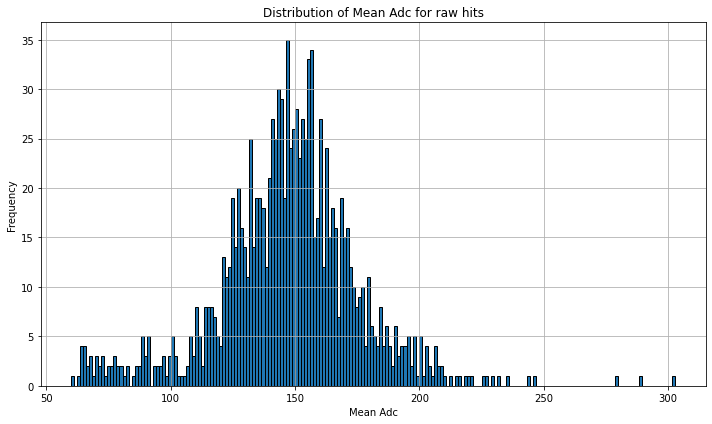

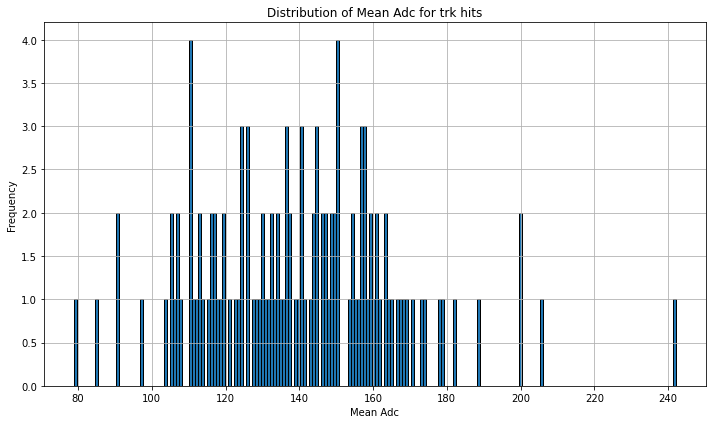

None None


In [47]:
print(meanAdc_hist(df_raw_grouped_data, 'raw'), meanAdc_hist(df_trk_grouped_data, 'trk'))

In [46]:
# meanADC 1D histogram
# Plot meanADC column as a 1D histogram
def meanAdc_hist(df, data_type):
    
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.hist(df['mean_adc'], bins=200, edgecolor='black')  # Create a histogram with 20 bins
    plt.xlabel('Mean Adc')  # Set the x-axis label
    plt.ylabel('Frequency')  # Set the y-axis label
    plt.title(f'Distribution of Mean Adc for {data_type} hits')  # Set the title
    plt.grid(True)  # Show grid
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot


# meanAdc_hist(Gp_Data) #checking the data(before applying mean_adc cut)


In [4]:
#FUNCTIONS DEFINED

#Give a tube id to each tube
def tube_id(row, chamber):
    # Grab the tube name
    tube_name = row['rawMdt_tubeInfo']  # Assuming the column name that holds the tube name is 'rawMdt_tubeInfo'
    # Split the tube name once and unpack into components
    _, ml_index, ly_index, tube_no = tube_name.split('-')
    # Convert string indices to integers
    ml_index = int(ml_index)
    ly_index = int(ly_index)
    tube_no = int(tube_no)
    
    unique_tube_id = ((ml_index - 1) * chamberlist_run3.MDTnTml(chamber, 1) +
                      (ly_index - 1) * chamberlist_run3.MDTnTly(chamber, ml_index) +
                      tube_no)
    return unique_tube_id

#INTRODUCE ADC CUT
def adc_cut(df,cut):  #returns complete dataframe just introducing adc_cut(doesn't give any info on noise_rate etc)
    df_adc=df[df['rawMdt_adc']>=cut]
    return df_adc
    

#ADD TUBE_ID AND NOISE RATE COLUMNS TO THE ORIGINAL DATFAFRAME
def noise_rate(df_op_chamber):
    df_op_chamber.loc[:,'Tube_ID']=df_op_chamber.apply(lambda row: tube_id(row, OP_CHAMBER),axis=1)
    tube_hits = df_op_chamber['rawMdt_tubeInfo'].value_counts()
    df_op_chamber.loc[:,'Tube_hits']=df_op_chamber['rawMdt_tubeInfo'].map(tube_hits)
    df_op_chamber.loc[:,'Noise_rate']=df_op_chamber['Tube_hits']/(ACTIVE_TIME_WINDOW*total_evts)  #returns the original dataframe with added columns of noise rate and tube id

    return df_op_chamber

#Extract list of noisy_tubes and dataframe removing noisy_tubes
def noisy_tubes(df):
    n_tubes=df[df['Noise_rate']>noise_thresh]['rawMdt_tubeInfo']
    # noise_thresh
    n_tb_list=n_tubes.unique().tolist()
    return n_tb_list




#PLOTS A HISTOGRAM FOR ALL VALUES OF ADC FOR A SINGLE TUBE
def adc_spectrum(df):

    fig,ax = plt.subplots(figsize=(8,6))
       
    # ADC count without cut
    mdt_adc = df.avg_adc.values.astype(float)
    min_adc = 50
    max_adc = 350
    
    xadc, xbins, patch = ax.hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc spectrum for a single tube')
    ax.set_xlabel('adc values')
    return 

#ADDS A COLUMN WITH MEAN ADC VALUES TO DF WITH ADC CUT
def calculate_avg_adc(df):
    df['Avg_adc']=df.groupby('rawMdt_tubeInfo')['rawMdt_adc'].transform('mean') #groups data wrt tubeinfo uniue values ie tube names and transform 
                                          # calculates avg values of the adc column are projects the values back to respective columns.
    return df

#RETURNS A DATAFRAME EXCLUDING ALL THE NOISY TUBES
def df_filtered(df):         
    # df_raw_adc_cut=adc_cut(df,cut)  #Complete dataframe after introducing adc_cut

    df_raw_chamber_noisy_filtered=df[~df['rawMdt_tubeInfo'].isin(noisy_tubes_list)]
    return df_raw_chamber_noisy_filtered

#RETURNS A DATAFRAME OF ALL THE NOISY TUBES
def df_raw_noisy(df,cut):         
    df_raw_adc_cut=adc_cut(df,cut)  #Complete dataframe after introducing adc_cut

    df_raw_noise=df_raw_adc_cut[df_raw_adc_cut['rawMdt_tubeInfo'].isin(noisy_tubes_list)]
    return df_raw_noise

#Noise_Rate v/s Tube_Id Plot
def plot_for_noise_rate(df, chamber, cut,noise_thresh):
    run='456729'
    fig,axes = plt.subplots(figsize=(28, 32), nrows = 3, ncols = 1)  
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
    alpha_value = 1  #Transparency
    
    # df_noise_rate=noise_rate(df_raw_chamber,OP_CHAMBER)
    df_noise_rate_sorted=df_noise_rate.sort_values(by='Tube_ID', ascending=True)
    
    axes[0].bar(df_noise_rate_sorted['Tube_ID'].astype(str), df_noise_rate_sorted['Noise_Rate'], color='skyblue')
    axes[0].set_title('Noise Rate without adc cut')
    axes[0].set_xlabel('Tube ID')
    axes[0].set_ylabel('Noise Rate')
    axes[0].set_xticks(np.arange(0, len(df_noise_rate_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut
    df_raw_chamber_with_adc_cut=adc_cut(df_raw_chamber,chamber,cut)
    df_noise_rate_with_adc_cut = noise_rate(df_raw_chamber_with_adc_cut,OP_CHAMBER)
    df_noise_rate_with_adc_cut_sorted = df_noise_rate_with_adc_cut.sort_values(by='Tube_ID', ascending=True) 


    axes[1].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[1].set_title('Noise Rate with adc cut before removing noisy tubes')
    axes[1].set_xlabel('Tube ID')
    axes[1].set_ylabel('Noise Rate')
    axes[1].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut
    df_raw_chamber_with_adc_cut=adc_cut(df_raw_chamber,chamber,cut)
    df_noise_rate_with_adc_cut = noise_rate(df_raw_chamber_with_adc_cut,OP_CHAMBER)
    df_noise_rate_with_adc_cut_sorted = df_noise_rate_with_adc_cut.sort_values(by='Tube_ID', ascending=True) 


    axes[1].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[1].set_title('Noise Rate with adc cut before removing noisy tubes')
    axes[1].set_xlabel('Tube ID')
    axes[1].set_ylabel('Noise Rate')
    axes[1].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut and noisy tubes removed
    df_raw_filtered=df_filtered(df_raw_chamber,chamber,cut,noise_thresh)
    df_noise_rate_removed=noise_rate(df_raw_filtered,chamber)
    df_noise_rate_removed_sorted=df_noise_rate_removed.sort_values(by='Tube_ID', ascending=True) 
    
    axes[2].bar(df_noise_rate_removed_sorted['Tube_ID'].astype(str), df_noise_rate_removed_sorted['Noise_Rate'], color='skyblue')
    axes[2].set_title('Noise Rate with adc cut after removing noisy tubes')
    axes[2].set_xlabel('Tube ID')
    axes[2].set_ylabel('Noise Rate')
    axes[2].set_xticks(np.arange(0, len(df_noise_rate_removed_sorted['Tube_ID'])+1, 50))
    # fig.savefig('Noise_rate for %s'%(chamber))
    plt.show()
    
# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber,plot_title):
    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    ax.set_title(plot_title)
    
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    # fig.savefig('Hitmap for %s'%(chamber))
# raw ADC and TDC hits plot with ADC cut at 50
def RawMdtplots(df,chamber,title):

    fig,axes = plt.subplots(figsize=(8, 3), nrows = 1, ncols = 2)
    # fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.4, hspace = 0.4)
    # fig.set_title(title, fontsize=20)
       
    # ADC count without cut
    mdt_adc = df.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0].set_xlim(min_adc,max_adc)
    axes[0].set_xlabel('adcCount',fontsize=15)
    axes[0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0].grid()
    axes[0].set_title(f'{chamber,title}_rawADC')
    
    
    # # raw TDC spectrum
    mdt_tdc = df.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1].set_xlim(min_tdc,max_tdc)
    axes[1].set_xlabel('tdcCount',fontsize=15)
    axes[1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1].grid()
    axes[1].set_title(f'{chamber,title}_rawTDC')
    
    fig.patch.set_facecolor('white')
    fig.savefig('Adc_Tdc for %s'%(chamber))
    plt.show()


In [ ]:
/eos/user/z/zyan/SWAN_projects/mdtCalibrationAnalysis/mdtAnalysisRun3/cbnt_run476785_24latest

In [16]:

Gp_Data=df_raw_op_chamber.groupby('rawMdt_tubeInfo').agg(mean_ADC=('rawMdt_adc', 'mean'),nHit=('rawMdt_adc','count')).reset_index()
Gp_Data

rawMdt_tubeInfo    mean_ADC  nHit
0      BIS5A02-1-1-1   66.000000     1
1     BIS5A02-1-1-10  134.000000     1
2     BIS5A02-1-1-12   99.000000     1
3     BIS5A02-1-1-13  159.000000     2
4     BIS5A02-1-1-14   66.000000     1
...              ...         ...   ...
1156  BIS7A02-2-4-95  197.388889    36
1157  BIS7A02-2-4-96  193.000000     1
1158  BIS7A02-2-4-97   74.232614   417
1159  BIS7A02-2-4-98  155.357143    28
1160  BIS7A02-2-4-99  195.458333    24

[1161 rows x 3 columns]

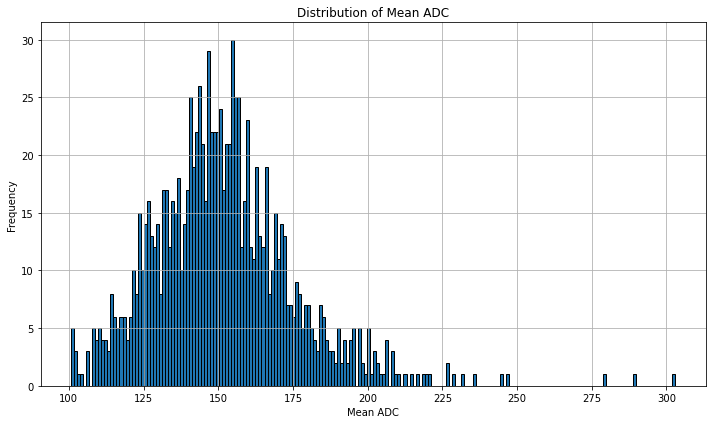

In [50]:
noisyTube = Gp_Data[Gp_Data['mean_ADC']> 100]
meanAdc_hist(noisyTube) #checking the data(after applying mean_adc cut)


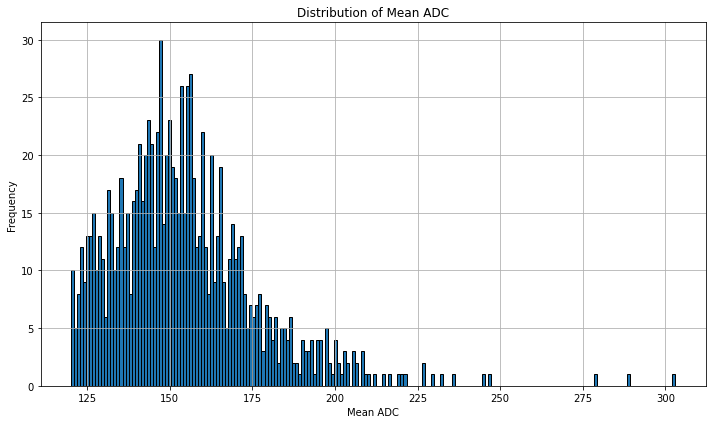

In [51]:
NoisyTube=Gp_Data[Gp_Data['mean_ADC']> 120]
meanAdc_hist(NoisyTube)

In [33]:
import ROOT

# Enable JSROOT for interactive plots (optional)
ROOT.enableJSVis()


 # Step 2: Extract data from the DataFrame
mean_adc_data = Gp_Data["mean_ADC"]

# Step 3: Create and fill a ROOT histogram
hist1 = ROOT.TH1F("hist1", "Distribution of Mean ADC;Mean ADC;Frequency", 80, mean_adc_data.min(), mean_adc_data.max())

for value in mean_adc_data:
    hist1.Fill(value)

# Step 4: Draw and display the histogram using ROOT
canvas1 = ROOT.TCanvas("canvas1", "Mean ADC Histogram", 1000, 600)
hist1.SetLineColor(ROOT.kBlack)
hist1.SetLineWidth(1)
hist1.Draw()
canvas1.SetGrid()
canvas1.Update()
# canvas.SaveAs("meanADC_histogram_bins70.png")

# Keep the GUI open (necessary for interactive use)
input("Press Enter to exit...")

Press Enter to exit... 


''

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas1


In [9]:
import ROOT


def plot_histogram(df, tube_name):
    # Filter the DataFrame
    filtered_df = df[df['rawMdt_tubeInfo'] == tube_name]

    # Create a ROOT histogram
    min_val = filtered_df['rawMdt_adc'].min()
    max_val = filtered_df['rawMdt_adc'].max()
    hist = ROOT.TH1F("hist", f"1D Histogram of rawMdt_adc for tube {tube_name};rawMdt_adc;Frequency", 200, min_val, max_val)

    # Fill the histogram
    for value in filtered_df['rawMdt_adc']:
        hist.Fill(value)

    # Create a canvas to draw the histogram
    canvas = ROOT.TCanvas("canvas", f"1D Histogram of rawMdt_adc for tube {tube_name}", 1000, 600)

    # Draw the histogram
    hist.SetLineColor(ROOT.kBlack)
    hist.SetLineWidth(1)
    hist.Draw()

    # Set grid on canvas
    canvas.SetGrid()

    # Update the canvas to show the histogram
    canvas.Update()

    # Save the canvas as a PNG file
    # canvas.SaveAs(f"rawMdt_adc_histogram_{tube_name}.png")


# Plot the histogram
plot_histogram(df_raw_with_adcCut, 'BIS7A02-2-4-30')

Press Enter to exit... 


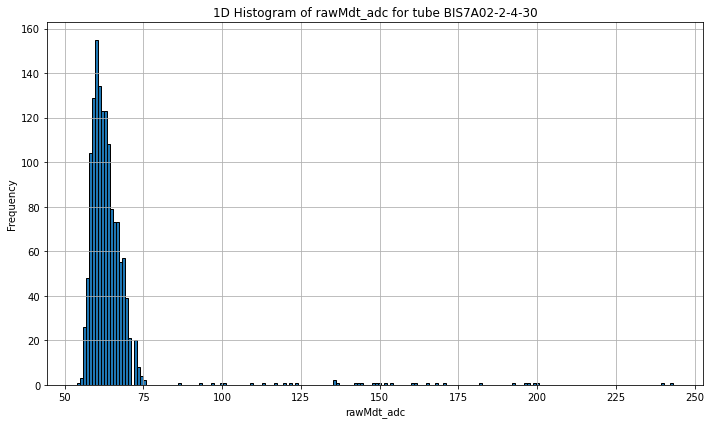

In [7]:
def plot_histogram(df, tube_name):
    filtered_df = df[df['rawMdt_tubeInfo'] == tube_name]
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df['rawMdt_adc'], bins=200, edgecolor='black')
    plt.xlabel('rawMdt_adc')
    plt.ylabel('Frequency')
    plt.title(f'1D Histogram of rawMdt_adc for tube {tube_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_histogram(df_raw_with_adcCut,'BIS7A02-2-4-30' )

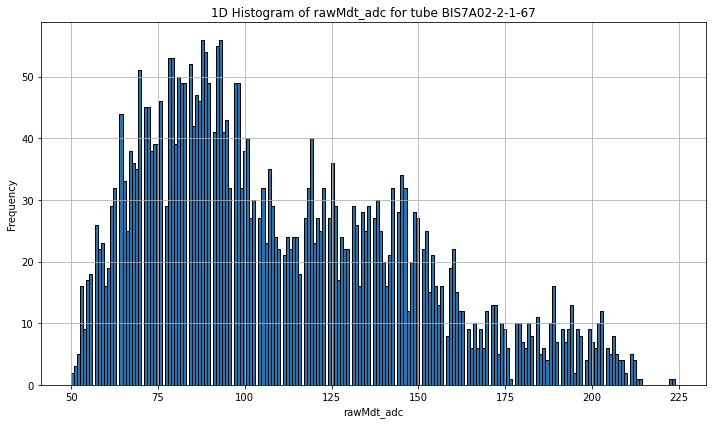

In [14]:
plot_histogram(df_raw_with_adcCut,'BIS7A02-2-1-67' )

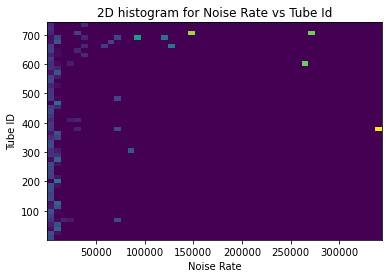

In [15]:
# Plot 2D histogram noiseRate vs TubeId by using df_raw before cut at noise rate 20k 
plt.figure()
plt.hist2d(df_raw_with_noise_rate['Noise_rate'],df_raw_with_noise_rate['Tube_ID'],bins=50)
plt.xlabel('Noise Rate')
plt.ylabel('Tube ID')
plt.title('2D histogram for Noise Rate vs Tube Id')
plt.show()

In [16]:
df_raw_with_noise_rate = df_raw_with_noise_rate.sort_values(by='Noise_rate')
df_raw_with_noise_rate.head(10)

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
8066  12               193   4310.543945   1778.790405   7167.180664   
7435  0                 65   4309.986328   1779.503296   6834.968750   
3588  33                80   4309.986328   1779.503296   6834.968750   
1319  11                75   4309.986328   1779.503296   6834.968750   
2924  13                60   4309.986328   1779.503296   6834.968750   
2465  3                 82   4309.986328   1779.503296   6834.968750   
4553  8                 87   4309.986328   1779.503296   6834.968750   
1917  5                 58   4309.986328   1779.503296   6834.968750   
3846  7                 68   4309.986328   1779.503296   6834.968750   
7941  0                 66   4309.986328   1779.503296   6834.968750   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
8066  12         24649695           135        1079  BIS7A02-2-4-96   
7435  0          24649673            88         471  BIS7A02-2-4-74   
3588  33         24649673           127           2  BIS7A02-2-4-74   
1319  11         24649673           116         625  BIS7A02-2-4-74   
2924  13         24649673           157         721  BIS7A02-2-4-74   
2465  3          24649673            63         190  BIS7A02-2-4-74   
4553  8          24649673           132         239  BIS7A02-2-4-74   
1917  5          24649673           100        1086  BIS7A02-2-4-74   
3846  7          24649673           122         107  BIS7A02-2-4-74   
7941  0          24649673           163         375  BIS7A02-2-4-74   

               rawMdt_station rawMdt_type  Tube_ID  Tube_hits  Noise_rate  
entry subentry                                                             
8066  12              BIS7A02         BIS      732          1   91.509727  
7435  0               BIS7A02         BIS      710          9  823.587547  
3588  33              BIS7A02         BIS      710          9  823.587547  
1319  11              BIS7A02         BIS      710          9  823.587547  
2924  13              BIS7A02         BIS      710          9  823.587547  
2465  3               BIS7A02         BIS      710          9  823.587547  
4553  8               BIS7A02         BIS      710          9  823.587547  
1917  5               BIS7A02         BIS      710          9  823.587547  
3846  7               BIS7A02         BIS      710          9  823.587547  
7941  0               BIS7A02         BIS      710          9  823.587547

In [53]:
import ROOT

Welcome to JupyROOT 6.30/04


In [17]:
# Get the nosiy tube list by using cut 20k : 
noisy_tube_list=df_raw_with_noise_rate[df_raw_with_noise_rate['Noise_rate']<=20000].rawMdt_tubeInfo.tolist()
print(f'Total number of noisy tubes for noise rate <= 20k: {len(np.unique(noisy_tube_list))}')

from collections import Counter
value_counts=Counter(noisy_tube_list)
# sorted_value_counts = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)
print(value_counts)

Total number of noisy tubes for noise rate <= 20k: 705
Counter({'BIS7A02-1-1-66': 177, 'BIS7A02-1-1-68': 170, 'BIS7A02-2-4-38': 137, 'BIS7A02-1-2-54': 123, 'BIS7A02-1-1-54': 121, 'BIS7A02-2-3-1': 121, 'BIS7A02-1-1-53': 121, 'BIS7A02-2-3-68': 117, 'BIS7A02-2-4-51': 116, 'BIS7A02-2-4-53': 115, 'BIS7A02-2-4-1': 114, 'BIS7A02-1-2-50': 111, 'BIS7A02-1-3-54': 111, 'BIS7A02-1-2-51': 111, 'BIS7A02-1-3-39': 111, 'BIS7A02-2-1-45': 109, 'BIS7A02-2-3-47': 109, 'BIS7A02-2-2-54': 109, 'BIS7A02-1-2-49': 107, 'BIS7A02-1-4-54': 106, 'BIS7A02-1-2-48': 106, 'BIS7A02-1-4-53': 105, 'BIS7A02-2-4-50': 104, 'BIS7A02-2-3-50': 103, 'BIS7A02-2-1-54': 103, 'BIS7A02-2-4-37': 103, 'BIS7A02-1-4-40': 102, 'BIS7A02-2-2-45': 102, 'BIS7A02-2-3-52': 101, 'BIS7A02-2-4-48': 101, 'BIS7A02-1-4-72': 101, 'BIS7A02-1-1-49': 100, 'BIS7A02-1-4-42': 100, 'BIS7A02-1-3-53': 100, 'BIS7A02-2-2-46': 100, 'BIS7A02-2-2-48': 100, 'BIS7A02-2-3-48': 98, 'BIS7A02-1-3-51': 98, 'BIS7A02-2-4-40': 98, 'BIS7A02-1-3-45': 98, 'BIS7A02-1-4-41': 98, 

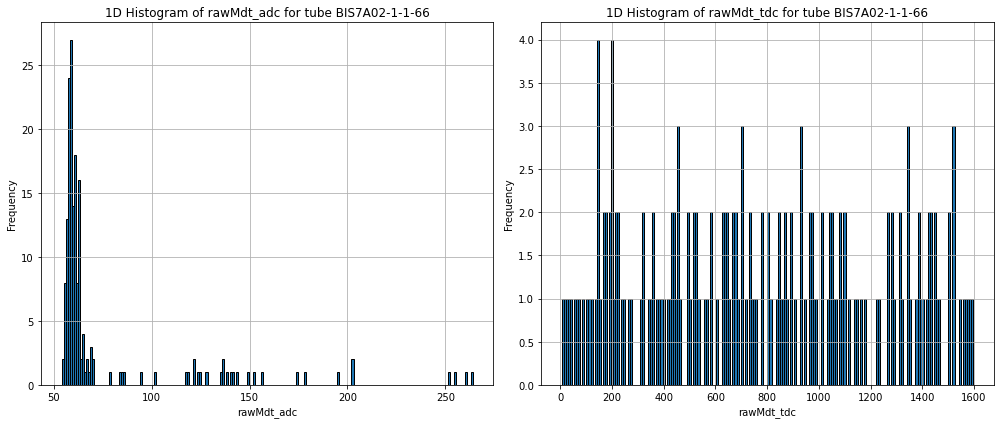

In [18]:
# Plot the ADC and TDC for the most noisy tube MLx-x-xx ('BIS7A02-1-1-66')

def plot_histograms(df, tube_name):
    # Filter the DataFrames to retain rows where 'rawMdt_tubeInfo' matches the tube names
    filtered_df = df[df['rawMdt_tubeInfo'] == tube_name]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the first histogram
    ax1.hist(filtered_df['rawMdt_adc'], bins=200, edgecolor='black')
    ax1.set_xlabel('rawMdt_adc')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'1D Histogram of rawMdt_adc for tube {tube_name}')
    ax1.grid(True)

    # Plot the second histogram
    ax2.hist(filtered_df['rawMdt_tdc'], bins=200, edgecolor='black')
    ax2.set_xlabel('rawMdt_tdc')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'1D Histogram of rawMdt_tdc for tube {tube_name}')
    ax2.grid(True)

    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

plot_histograms(df_raw_with_noise_rate, 'BIS7A02-1-1-66')

In [41]:
# Group by 'tube id', calculate the mean of 'rawMdt_adc', and count the number of hits
grouped_data_tube_id = df_raw_with_adcCut.groupby('Tube_ID').agg(
    mean_ADC=('rawMdt_adc', 'mean'),
    nHit=('rawMdt_adc', 'count')
).reset_index()
grouped_data_tube_id = grouped_data_tube_id.sort_values(by='mean_ADC')
print(grouped_data_tube_id.head(5))


     Tube_ID   mean_ADC  nHit
699      708  59.962963    27
379      380  62.520885   814
618      625  63.758950   419
645      654  64.413183   622
691      700  64.665663   332


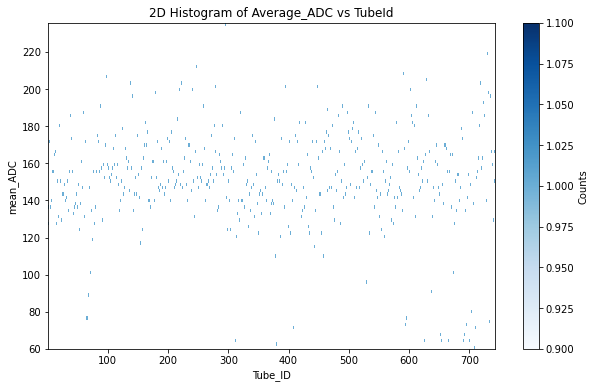

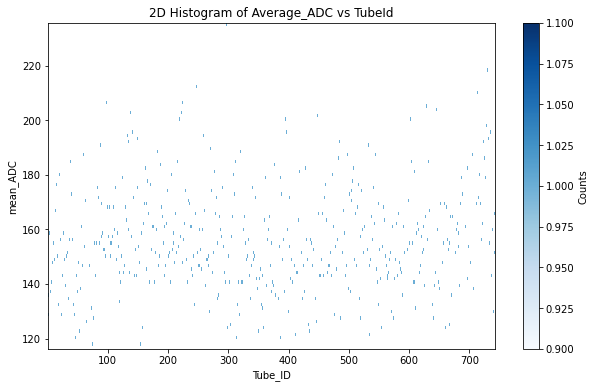

In [43]:
# Plot 2D histogram AverageADC vs TubeId by using df_adcCut

def plot_2d_hist(df):

    x=df['Tube_ID']
    y=df['mean_ADC']
    plt.figure(figsize=(10, 6))
    plt.hist2d(x,y , bins=[len(np.unique(x)), 100], cmap='Blues', cmin=1)
    cbar = plt.colorbar()  # Add a colorbar
    cbar.set_label('Counts')

    plt.xlabel('Tube_ID')
    plt.ylabel('mean_ADC')
    plt.title('2D Histogram of Average_ADC vs TubeId')

    plt.show()

plot_2d_hist(grouped_data_tube_id)
filtered_tubes = grouped_data_tube_id[grouped_data_tube_id['mean_ADC']> 115]
plot_2d_hist(filtered_tubes)

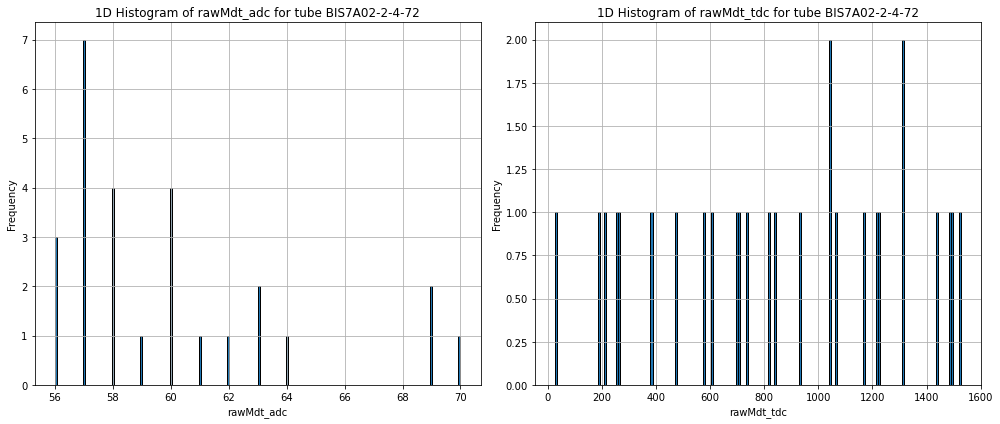

In [49]:
# Plot the ADC and TDC for the lowest AverageADC tube BIS7A02-2-4-72 (704)
# Grouped_data = grouped_data.sort_values(by='mean_ADC')
plot_histograms(df_raw_with_noise_rate, 'BIS7A02-2-4-72')

Info in <TCanvas::Print>: png file histogram.png has been created


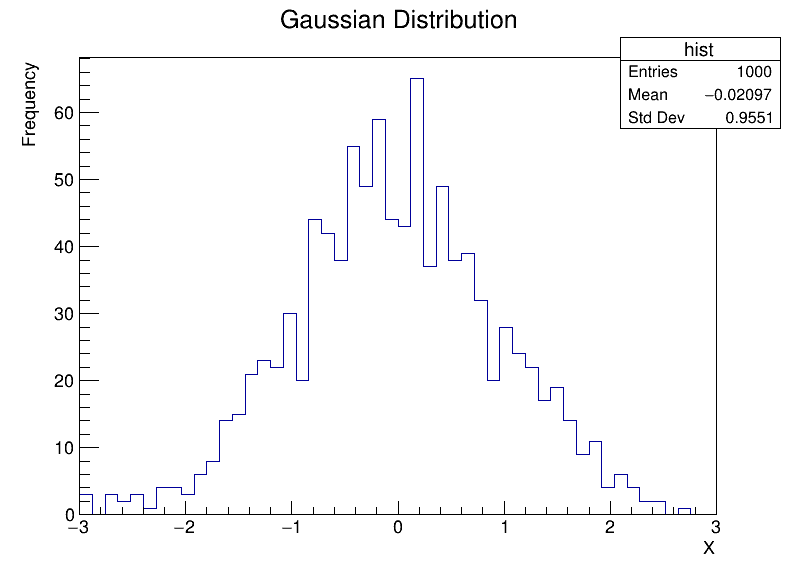

In [56]:
import ROOT


# Create a canvas
canvas = ROOT.TCanvas("canvas", "PyROOT Example", 800, 600)

# Generate some random data
data = np.random.normal(loc=0, scale=1, size=1000)

# Create a histogram
hist = ROOT.TH1F("hist", "Gaussian Distribution;X;Frequency", 50, -3, 3)

# Fill the histogram with data
for value in data:
    hist.Fill(value)

# Draw the histogram
hist.Draw()

# Update and save the canvas
canvas.Update()
# canvas.SaveAs("histogram.png")

# Display the canvas
canvas.Draw()

In [58]:
import ROOT
import numpy as np

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Interactive PyROOT Example", 800, 600)

# Generate some random data
data = np.random.normal(loc=0, scale=1, size=1000)

# Create a histogram
hist = ROOT.TH1F("hist", "Gaussian Distribution;X;Frequency", 50, -3, 3)

# Fill the histogram with data
for value in data:
    hist.Fill(value)

# Draw the histogram
hist.Draw()

# Update the canvas
canvas.Update()

# Integrate JSROOT with Jupyter Notebook for interactive plotting
import jsroot
jsroot.enableNotebook()

# Display the canvas
jsroot.display(canvas)

ModuleNotFoundError: No module named 'jsroot'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


In [60]:
pyhton3 -m pip install jsroot

SyntaxError: invalid syntax (3436515741.py, line 1)